# SSW2023 petitRADTRANS Retrieval Exercises

## Author: Paul Molliere (Max Planck Institute for Astronomy)

This hands-on session exercise makes heavy use of the petitRADTRANS retrieval package, which was developed by Evert Nasedkin.

Run the [SWW2023_Retrievals_using_petitRADTRANS_Setup](https://colab.research.google.com/drive/1KwHnZsjScd6v1vmF1qdJN2iHkLRK-dt9?usp=sharing) notebook to download the data. The setup notebook needs to just be run **once**  once for Hands-on Session IV.

## Google Colab Usage

*Please read (don't just hit run) the information given above each code cell as there are separate install cells for Colab*
&#128992;
*and running Python on your computer*
&#128309;.

**Confirm login account**
* Please make sure to be logged in with the Google account you want to use for the exercises before running the code cells below. You can check by clicking the circular account icon in the top right corner of the colab notebook.

**Working directory**
* Note: The software and data will be installed in a directory called "SSW2023/pRT" in your Google drive. This directory will be created if it does not exist.

**Running cells**
* Run cells individually by clicking on the triangle on each cell

**To Restart runtime**
*   Click on Runtime menu item
*   Select Restart runtime
*   Select Run code cells individually from the top

**To Recreate runtime**
*   Click on Runtime menu item
*   Select Disconnect and Delete runtime
*   Select Run code cells individually from the top

**To Exit:**
*   Close the browser window

# &#128992; When running on Colab: pRT installation and setup

This cell installs everything you need in Colab, as explained in the hands-on session's documentation.

&#128992; **Run this cell if you are running on Colab**

In [ ]:
import os

# Install MultiNest
os.chdir('/content/')
!rm -rf multinest
!git clone https://www.github.com/johannesbuchner/multinest.git
!cd multinest/build && cmake ..
!sed -i 's/-lmkl_gf_lp64 -lmkl_gnu_thread/-lmkl_mc3 -lmkl_rt -lmkl_avx2/' multinest/build/src/CMakeFiles/multinest_shared.dir/link.txt
!cd multinest/build && make && make install
!cp /content/multinest/lib/* /lib/

# Install petitRADTRANS (pRT)
import numpy as np
!pip install --no-cache-dir -U petitRADTRANS

&#128992; **Run the  2 cells if you are running on Colab**

This cell mounts the Google Drive (please allow it to do so) and specifies the path of the pRT input data folder. If you *are* running on Colab, but changed the default path specified in the setup notebook, please modify the path to correctly point to the input data in your Google Drive.

"SSW2023/pRT" is the default and you can leave that as-is or change it in the fill in box on the right. Be sure to pick a directory name that does not have any spaces. *This must match the directory used in the setup notebook.* This cell must be run to define the data location.

In [1]:
# If you update the directory in the box on the right, re-run this cell
pRT_dir = 'SSW2023/pRT' #@param {type:"string"}

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount("/content/drive")

# Google top level drive dir
drive_dir = "/content/drive/MyDrive/"

# pRT directory path
pRT_path = os.path.join(drive_dir, pRT_dir)

# Confirm directory already exists per Setup
if os.path.exists(pRT_path):
  print("OK! directory '%s' exists" %pRT_path)
else:
  print("Run Setup directory '%s' does not exist" %pRT_path)

# Specify location of pRT's input data
os.environ['pRT_input_data_path'] = \
                  pRT_path+'/pRT_retrieval_SSW/input_data'

Let's switch to the `pRT_retrieval_SSW/retrievals` folder for running the retrieval:  

&#128992; **Run this cell if you are running on Colab**

In [5]:
os.chdir(pRT_dir)

# &#128309; When running on your computer:
Please modify `absolute_path_of_the_pRT_retrieval_SSW_folder_on_your_machine` below to point to the `pRT_retrieval_SSW` folder you downloaded as described in the documentation. Then run the cell below to set the `pRT_input_data_path` environment variable accordingly. This is done such that pRT knows where the input data is.

&#128309; **Run this cell if running on your computer (not Colab!)**

In [2]:
absolute_path_of_the_pRT_retrieval_SSW_folder_on_your_machine = '/Users/nasedkin/python-packages/petitRADTRANS/docs/content/notebooks/pRT_retrieval_SSW' # Please complete!

import os
import numpy as np

os.environ['pRT_input_data_path'] = \
    os.path.join(absolute_path_of_the_pRT_retrieval_SSW_folder_on_your_machine,
                 'input_data')

Let's switch to the `pRT_retrieval_SSW/retrievals` folder for running the retrieval.

&#128309; **Run this cell if running on your computer (not Colab!)**

In [3]:
os.chdir(os.path.join(absolute_path_of_the_pRT_retrieval_SSW_folder_on_your_machine,
                 'retrievals'))

# What is a retrieval?
As you learned in the lecture by Mike Line, in retrievals we try to constrain the properties of an atmosphere, given an observation. For your reference, we will repeat the most important concepts here.

## Classical $\chi^2$-minimization
Many of you may have come across the concept of "fitting an observation" by so-called $\chi^2$-minimization. In short, one the minimizes the following quantity
\begin{equation}
\chi^2 = \sum_{i=1}^{N_\lambda}\frac{(y_i-f_i)^2}{\epsilon_i^2},
\end{equation}
where $y_i$ are the observed data points, $f_i$ is the model prediction of said data points, $\epsilon_i$ is the measurement uncertainty, and $N_{\lambda}$ is the number of data points. If we assume that the measuring uncertainties follow a Gauss distribution and that the measurements are independent, then the probability of observing the data $\mathbf{y}$, given the model prediction $\mathbf{F}(\mathbf{x})$, where $\mathbf{x}$ are the free parameters of the model, would be
\begin{equation}
P(\mathbf{y}|\mathbf{x}) = Ce^{-\chi^2/2}.
\end{equation}
Here $C$ is a normalization constant, ensuring that $\int P(\mathbf{y}|\mathbf{x})d\mathbf{y}=1$, as must be the case for any probability distribution. Note that we expressed the data, model, and model parameters as vectors now (so $\mathbf{y}$, $\mathbf{F}$, and $\mathbf{x}$, respectively; so $\mathbf{F}$ has elements $f_i$). $\chi^2$ is thus related to $P(\mathbf{y}|\mathbf{x})$ as shown above, and by minimizing $\chi^2$ we look for a set of parameter values $\mathbf{x}_{\rm best}$ that maximize $P(\mathbf{y}|\mathbf{x})$.

It is potentially not a bad assumption that $\mathbf{x}_{\rm best}$ is related to the most likely model parameters, given the measurement. But we would like to know the *actual* distribution of $\mathbf{x}$ that are consistent with the data.

## Retrieval definition

Retrievals do just that: they provide us with an estimate of $P(\mathbf{x}|\mathbf{y})$ (instead of maximizing $P(\mathbf{y}|\mathbf{x})$). They thus answer the question: "*what is the probability distribution of model parameter values, given an observation?*" For an atmospheric retrieval we do this by constructing a so-called "forward model" that can generate synthetic (and noise-free) observations as a function of the atmospheric properties, which are expressed through the parameters of the forward model. The forward model is then compared to the data repeatedly with different parameter values, in order to determine the distribution of parameter values, given the data.

Analogous to what we discussed above, we now define the following quantities: $\mathbf{y}$ is the data, in this case a vector of length $N_\lambda$ that contains the observed flux values $y_i$ at $N_\lambda$ wavelength points (so index $i$ runs from 1 to $N_\lambda$). The vector $\epsilon$ (also of length $N_\lambda$) contains the associated uncertainties $\epsilon_i$ for the measured flux values $y_i$. Next we define the vector $\mathbf{x}$ which has the length $N_{\rm param}$. This vector encodes the properties of the atmosphere for our forward model; $N_{\rm param}$ is therefore the number of parameters. For example, $x_1$ may be the temperature at the top of the atmosphere, $x_2$ may be the temperature at the bottom, $x_3$ may be the abundance of the important absorber H$_2$O, etc. Finally, the forward-model $\mathbf{F}(\mathbf{x})$ is a function that takes in the vector $\mathbf{x}$ and predicts a synthetic (noise-free) observation by solving the radiative transfer equation, modeling the observational process, etc. That means that the output of $\mathbf{F}(\mathbf{x})$ is also a vector of length $N_{\rm \lambda}$, like the observation $\mathbf{y}$.

As stated above, with a retrieval we want to solve for $P(\mathbf{x}|\mathbf{y})$, so the probability distribution of forward model parameters, given the observation. This desired distribution is called "posterior distribution" (or just "posterior"). Using [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem), we can express the posterior like this
$$
P(\mathbf{x}|\mathbf{y}) = \frac{1}{P(\mathbf{y})}\underbrace{P(\mathbf{x})}_{\rm "Prior"} \underbrace{P(\mathbf{y}|\mathbf{x})}_{\rm "Likelihood"}.
$$
Here, $P(\mathbf{y})$ can again be regarded as a constant, ensuring that $\int P(\mathbf{x}|\mathbf{y}) d\mathbf{x}=1$. The two other terms are the prior and the likelihood, described in the following paragraphs.

### Priors

The "prior" $P(\mathbf{x})$ is an important quantity and in fact a key difference between a retrieval and a classical fit via $\chi^2$ minimization. The prior encodes any *prior* knowledge that we had about the atmosphere *before* making the observation. An obvious example for a prior would be $P(T<0) = 0$, that is, temperatures cannot be negative. We may also have an independent measurement of the planet's mass and radius, giving rise to a prior on the planet's atmospheric gravity. If we lack any prior information for a given parameter, we will use a broad, "uninformative" prior distribution (usually uniform or log-uniform).

## Log-likelihood

The likelihood brings our old accquaintance  $\chi^2$ back. It answers the question: "How likely is it that we observed the data $\mathbf{y}$, assuming that $\mathbf{x}$ correctly describes the state of the atmosphere?" Assuming that the data points have independent uncertainties that follow a Gauss (normal) distribution we can write
$$
P(\mathbf{y}|\mathbf{x}) = \prod_{i=1}^{N_\lambda}\frac{1}{\sqrt{2\pi\epsilon_i^2}}{\rm exp}\left[-\frac{(y_i-f_i)^2}{2\epsilon_i^2}\right],
$$
where $f_i$ is the $i$-th element of $\mathbf{F}(\mathbf{x})$. Here we fully wrote out the expression $P(\mathbf{y}|\mathbf{x}) = Ce^{-\chi^2/2}$ that we saw above.

Since during the retrieval it can happen that we compare very small to very large likelihood values (which is challenging numerically) it is customary to work in log-space. In this case the likelihood (usually denoted by $L$) becomes the so-called "log-likelihood" ${\rm log}(L)$:
$$
{\rm log}(L) = -\frac{1}{2}\sum_{i=1}^{N_\lambda}\frac{(y_i-f_i)^2}{\epsilon_i^2} + C,
$$
where $C=-0.5\sum_{i=1}^{N_{\lambda}}{\rm log}(2\pi \epsilon_i^2)$ is a constant in case that the uncertainties are fixed. This is usually the case, but note that sometimes the magnitude of the uncertainties is also a free parameter of the retrieval. The log-likelihhod therefore simply is
$$
{\rm log}(L) = -\frac{\chi^2}{2}+C.
$$

## Retrieval practicalities
The goal of a retrieval is to determine the posterior $P(\mathbf{x}|\mathbf{y})$. The problem is that we usually cannot simply analytically (or even numerically) calculate this function. Instead, retrieval methods make use of the fact that we can straightforwardly calculate prior and likelihood values once a forward model has been defined and a set of parameter values has been selected. Commonly used retrieval setups then employ the so-called "nested sampling" method. All it does is to generate samples of $P(\mathbf{x}|\mathbf{y})$. So while we do not know the exact functional form of $P(\mathbf{x}|\mathbf{y})$, we know how to sample from it. For this the forward model has to be called many (thousands to hundreds of millions of) times and compared to the data. Sample suggestions which are more probable, given the prior, and more consistent with the data, given the likelihood, are more likely to be accepted. This process is also called "inverting the forward model", and can be very computationally expensive.

# Retrieval setup
We begin by loading the packages we will need below:

In [4]:
from matplotlib import pyplot as plt

from petitRADTRANS import Radtrans
from petitRADTRANS import nat_cst as nc
from petitRADTRANS.retrieval import rebin_give_width as rgw
from petitRADTRANS.retrieval.util import calc_MMW
from petitRADTRANS.retrieval import parameter as pm
from petitRADTRANS.retrieval import Retrieval,RetrievalConfig

## Preparing the data
In what follows, we will use the blue and the red part of the NIRSPec G395H spectrum of the hot Jupiter WASP-39b ([Alderson et al. 2023](https://www.nature.com/articles/s41586-022-05591-3)), as published on [Zenodo](https://zenodo.org/record/7185300#.ZGE9GHZByxq). WASP-39b is famous for being the first planet in which photchemically produced SO$_2$ was detected with JWST. We will try the same with the G395H data here. In order to have retrievals run quickly enough, we will run at a low spectral resolution, however. So we will bin down the two spectra (weighted_average_WASP_39b_transmission_1.dat and weighted_average_WASP_39b_transmission_2.dat). In principle you could also use the G395H transmission spectrum of WASP-39b that you derived in hands-on session 2. Here we will use the Zenodo version to minimize the risk of formatting errors (we do not have much time!). Maybe you want to try your own reduction later / "offline"? First we load the two files here at intrinsic resolution from the hands-on session input data folder, to get a first impression of the data. The putative SO$_2$ feature appears at ~4-4.2 µm.

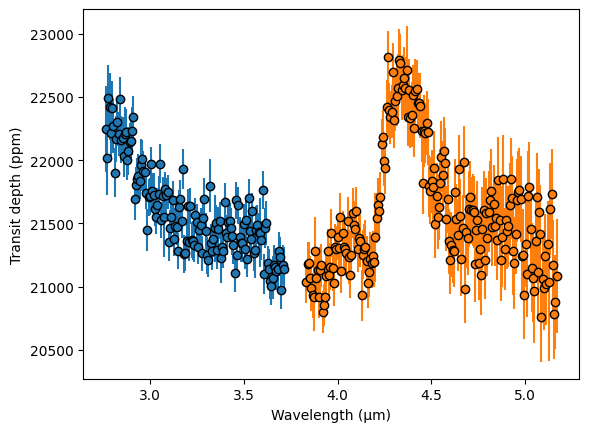

In [5]:
input_data_blue = np.genfromtxt('../observations/'
                             'weighted_average_WASP_39b_transmission_1.dat')

plt.errorbar(input_data_blue[:,0],
             input_data_blue[:,1]*1e6, # multiply by 10^6 to convert to depth in units of ppm, for the plot.
             yerr = input_data_blue[:,2]*1e6,  # multiply by 10^6 to convert to depth in units of ppm, for the plot.
             marker='o', linestyle='',markeredgecolor='k')

input_data_red = np.genfromtxt('../observations/'
                             'weighted_average_WASP_39b_transmission_2.dat')
plt.errorbar(input_data_red[:,0],
             input_data_red[:,1]*1e6, # multiply by 10^6 to convert to depth in units of ppm, for the plot.
             yerr = input_data_red[:,2]*1e6, # multiply by 10^6 to convert to depth in units of ppm, for the plot.
             marker='o', linestyle='',markeredgecolor='k')

plt.xlabel('Wavelength (µm)')
plt.ylabel('Transit depth (ppm)')

plt.show()

The code below bins the data down to a wavelength spacing of $\lambda/\Delta \lambda = 100$, which is exactly the resolution and bin positions that we will be using for the retrieval. The files will be stored in a new folder called "observations". It will plot the rebinned spectra as well. Note that the errorbars are properly propagated in the process (so will be smaller after binning down). No point in understanding what the code here does in detail. Please just run it!

mkdir: observations: File exists


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_100...
 Done.



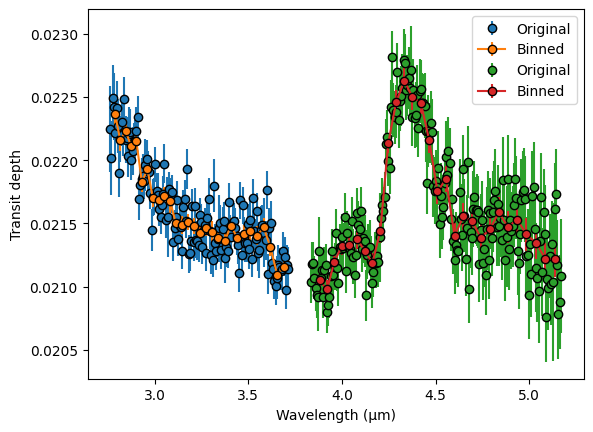

In [6]:
!mkdir observations
line_species = ['H2O_Exomol_R_100']
atmosphere = Radtrans(line_species = line_species)
bins_borders_take = nc.c/atmosphere.border_freqs/1e-4
bins_borders_take_freq = atmosphere.border_freqs

nirspecs_dict = {}
nirspecs_dict['blue'] = [input_data_blue[:,0], input_data_blue[:,1], input_data_blue[:,2]]
nirspecs_dict['red']  = [input_data_red[:,0], input_data_red[:,1], input_data_red[:,2]]

i_d = 1
for key in nirspecs_dict.keys():

    wavelens, widths = [], []
    wavelens = np.array((bins_borders_take_freq[1:]+bins_borders_take_freq[:-1])/2.)
    wavelens = nc.c/wavelens/1e-4
    widths = np.diff(bins_borders_take)

    index = (wavelens-widths/2. >= nirspecs_dict[key][0][0]) & \
          (wavelens+widths/2. <= nirspecs_dict[key][0][-1])

    wavelens = wavelens[index]
    widths = widths[index]

    bin_flux = rgw.rebin_give_width(nirspecs_dict[key][0],
                                    nirspecs_dict[key][1],
                                    wavelens,
                                    widths)


    plt.errorbar(nirspecs_dict[key][0],
                 nirspecs_dict[key][1],
                 nirspecs_dict[key][2],
                 marker='o', linestyle='',
                 markeredgecolor='k',label='Original')

    errs = np.ones_like(bin_flux)

    for i_wlen in range(len(wavelens)):
        inpoints = (nirspecs_dict[key][0] >= (wavelens[i_wlen] - widths[i_wlen]/2.)) & \
            (nirspecs_dict[key][0] <= (wavelens[i_wlen] + widths[i_wlen]/2.))
        npoints = len(nirspecs_dict[key][0][inpoints])
        errs[i_wlen] = np.sqrt(np.sum(nirspecs_dict[key][2][inpoints]**2.)) / npoints

    plt.errorbar(wavelens, bin_flux, errs,marker='o',
                linestyle='-',markeredgecolor='k',label='Binned')

    np.savetxt('../observations/weighted_average_WASP_39b_transmission_' \
               +str(i_d)+'_R100_pRT_grid.dat',
              np.column_stack((wavelens, widths, bin_flux, errs)),
              header = 'central wavelength[um]     wavelength bin width[um]    '
                       'depth     depth error     ')

    i_d += 1

plt.xlabel('Wavelength (µm)')
plt.ylabel('Transit depth')
plt.legend()
plt.show()

## Defining the retrieval run
Here we just give a name to the run, such that we can find the corresponding files in the result folders later. We also define the `run_mode`: it is equal to `'retrieve'` if we want to run a retrieval and equal to `'evaluate'` if we just want to plot run results. We also define the pressure array of the atmospheric structure. Here we go for 30 layers, equidistantly log-spaced between $10^{-8}$ and 100 bar. **Note that we only use 30 layers here such that retrievals finish quickly enough on Colab. Usually we recommend 100 or more layers.** For the retrievals presented here we did not actually see a difference when running at higher vertical resolution (100 layers) though. The run mode, retrieval name and pressure array will be used to generate a `RetrievalConfig` object that we call `RunDefinition`, which we will use to further define the retrieval below.

In [7]:
run_name = 'transmission_WASP-39b'
run_mode = 'evaluate' # or 'retrieve' or 'evaluate'

RunDefinition = RetrievalConfig(retrieval_name = run_name,
                                      run_mode = run_mode,
                                      pressures=np.logspace(-8, 2, 30))

## Setting up the fixed parameters
Here we will use the `add_parameter()` method of the Retrieval config class, to add fixed parameters that our forward model can access. The values of fixed parameters will not be retrieved. The first argument of the `add_parameter()` method is the name of the parameter. The second is a boolean variable (so either `True`or `False`) which determines whether a parameter is free (so use `True`) or fixed (use `False`).

### Exercise 1:
Look at the code cell below, where the stellar and plantary radii are added as fixed parameters. By filling in the blanks, also add the the planetary mass as a fixed parameter `M_pl`, using this value: `0.281 * nc.m_jup`. The parameter `'M_pl'` is needed in the forward model, together with `'R_pl'`, to calculate the atmospheric gravitational acceleration. [You can click here to see if your solution is correct](https://www2.mpia-hd.mpg.de/~molliere/SSW/solutions_notebook_2.html#Exercise-1:).

In [8]:
input_R_star = 0.939 * nc.r_sun
input_R_pl = 1.279 * nc.r_jup

RunDefinition.add_parameter('R_star',
                             False,
                             value = input_R_star)
RunDefinition.add_parameter('R_pl',
                             False,
                             value = input_R_pl)
input_M_pl = 0.281 * nc.m_jup # ...
RunDefinition.add_parameter('M_pl',
                             False,
                             value = input_M_pl)

## Setting up the free parameters
Next, we will set up the free parameters which we want to retrieve. Since they are no longer fixed, we will change the boolean variable to `True` when adding the free parameters. We will also set up the priors at the same time. For every free parameter, the sampling technique Multinest provides us with a uniformly distributed random variable $z$, between 0 and 1. We have to provide functions to map $z$ to the actual parameter values of interest. Imagine, for example, that we would like to put a uniform prior on the atmospheric temperature, from $T_0$ to $T_1$. We would then map $z$ to $T$ like this: $T = T_0 + (T_1-T_0)z$. This makes sense since for $z=0$ we have $T=T_0$, while for $z=1$ we have $T=T_1$. Since there is a linear dependence between $T$ and $z$, $T$ will also be uniformly distributed. We can thus define a mapping function for the uniformly distributed temperature, assuming $T_0 = 200 \ {\rm K}$ and $T_1 = 2000 \ {\rm K}$:
```
function = lambda z : 200 + 1800 * z
```
Here we used the so-called lambda function of Python, which allows to define functions in one line. It is equivalent to:
```
def function(z):
    return 200 + 1800 * z
```

A Gaussian prior mapping would be implemented like this
```
from petitRADTRANS.retrieval.util import gaussian_prior
function = lambda z : gaussian_prior(z, 1000., 100.)
```
In this case the function would map a uniformly distributed random variable z that goes from 0 to 1 to a normally distributed temperature with a mean value of 1000 K and a standard deviation of 100 K. For statistics cognoscenti: this is achieved by using the inverse of the cumulative gaussian probability distribution.

### Exercise 2:
Setup the following free parameters:

*   The reference radius for intergrating the hydrostatic pressure equation, `'R_pl_free'`, uniformly distributed between 0.5 and 1.5 Jupiter radii (so `0.5*nc.r_jup` to `1.5*nc.r_jup`).
*   The atmospheric temperature, `'Temperature'`, uniformly distributed between 200 and 2000 K. We will only retrieve one temperature value here, because we will assume that the atmosphere is isothermal (i.e., has the same temperature at all pressures).
*   The log10 value of the cloud top pressure (in bar), `'log_Pcloud'`, uniformly distributed between -8 and 2 (corresponding to $10^{-8}$ and $100$ bar).

Note that this here would be the correct way of setting up a free parameter `'x'` that is uniformly distributed between $x_0$ and $x_1$:
```
RunDefinition.add_parameter('x',
                             True,
                             transform_prior_cube_coordinate =
                                  lambda z : x0 + (x1-x0)*z)
```
[You can click here to see if your solution is correct](https://www2.mpia-hd.mpg.de/~molliere/SSW/solutions_notebook_2.html#Exercise-2:).

In [9]:
# Solution Exercise 2
RunDefinition.add_parameter('R_pl_free',
                             True,
                             transform_prior_cube_coordinate =
                                  lambda x : (0.5 + 1.0*x) * nc.r_jup) 

RunDefinition.add_parameter('Temperature',
                             True,
                             transform_prior_cube_coordinate =
                                  lambda x : (200 + 1800.0*x)) 

RunDefinition.add_parameter('log_Pcloud',
                             True,
                             transform_prior_cube_coordinate =
                                  lambda x : (-8 + 10*x)) 

### Free parameters for the abundance of atmospheric absorbers
The next step would be to set up the free parameters for the absorber abundances. For example, the following code would add a free parameter `'H2O'` to the retrieval setup, which would actually retrieve the log mass fraction of H$_2$O between -10 to 0 with a uniform prior (corresponding to mass fractions between $10^{-10}$ and 1). In this particular case we would then assume the absorber abundance to be vertically constant.
```
RunDefinition.add_parameter('H2O',
                             True,
                             transform_prior_cube_coordinate =
                                  lambda x : (-10 + 10*x))
```
However, using such a setup is very common, and it may be that we add 10 or so line absorbers, which all would have an identical looking prior. So to make this quicker we implemented it in another way, which is described in the following.

## Adding absorber species
There are four different kinds of absorption cross-sections in pRT:

1.   Line absorption from molecules and atoms.
2.   Pseudo-continuum (i.e., changing slowly with wavelength) absorption of gas, such as collision-induced absorption (CIA) or bound-free and free-free absorption processes.
3.   Rayleigh scattering cross-sections by atmospheric gas species.
4.   Scattering and absorption cross-sections by clouds, for various cloud setups.

In the code cell below we add the line absorption of H$_2$O (from the Exomol line list), CO (from the HITEMP line list), CO$_2$ and SO$_2$. If there are multiple line lists available the distinction between them is made by adding a `'_line_list_name'` suffix to the species name. **We also tell the retrieval setup here to add free parameters for the line species' log mass fractions, from -10 to 0** (see `abund_lim = (-10.0,0.0)`). The `eq=False` means that it should actually add these parameters, while `eq=True` would mean that we provide (potentially modified) free abundance parameters to the run definition ourselves.


In [10]:
line_species = ['H2O_Exomol',
                    'CO_all_iso_HITEMP',
                    'CO2',
                    'SO2']

RunDefinition.set_line_species(line_species,
                               eq=False,
                               abund_lim = (-10.0,0.0))

Here we also add the Rayleigh absorption of H$_2$ and He, as well as CIA absoptions from H$_2$-H$_2$ and H$_2$-He collisions, which is required for describing the atmospheres of hot Jupiters.

In [11]:
rayleigh_species = ['H2', 'He']
continuum_opacities = ['H2-H2', 'H2-He']

RunDefinition.set_rayleigh_species(rayleigh_species)
RunDefinition.set_continuum_opacities(continuum_opacities)

## Defining a forward model for pRT's retrieval package

It is now time to define a forward model for the free parameters that we have defined above. What we want is a forward model for fitting a transmission spectrum of the hot Jupiter WASP-39b. Note that pRT's retrieval package will take care of modeling the observation itself, that is, convolving the forward model to JWST's resolution and binning it to detector pixel bins. All we need to do here is to define a function that takes in a pRT object and parameter values, and returns the model wavelengths and spectrum.



A forward model definition thus begins like this:
```
def forward_model(pRT_object,
                  parameters,
                  PT_plot_mode = False,
                  AMR = False):
```
where `pRT_object` is an instance of pRT's `Radtrans` class (don't worry about it, this will be generated by the retrieval later). `parameters` is a Python dictionary containing so-called parameter objects, based on the parameters we  defined above. The dictionary keys are identical to the parameter names, and `parameter['parameter_name'].value` accesses the value of the parameter, regardless of it being a free or a fixed parameter. The keyword arguments `PT_plot_mode = False` and `AMR = False` will not be discussed here, but please include them in your forward model definition.

### Exercise 3:
Please go through the forward model definition below (also read the comments) and familiarize yourself with it. This is the forward model we will use in our retrieval.

In [12]:
def WASP_39b_transmission_forward_model(pRT_object,
                            parameters,
                            PT_plot_mode = False,
                            AMR = False):

    # Never remove these three lines (not important to understand their
    # meaning right now):
    contribution = False
    if 'contribution' in parameters.keys():
        contribution = parameters['contribution'].value

    # DEFINING THE TEMPERATURE PROFILE
    # vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv

    # Make the P-T profile, here it is just an isothermal temperature profile
    pressures_bar = pRT_object.press/1e6 # get the pressure array defining
                                         # the atmosphere, including a cgs to
                                         # bar conversion (everything *inside*
                                         # pRT is in cgs units)
    temperatures = parameters['Temperature'].value * np.ones_like(pressures_bar)

    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

    # Never remove these two lines, they always must be placed after the
    # definition of the temperature structure (not important to understand
    # their meaning right now):
    if PT_plot_mode:
        return pressures_bar, temperatures

    # DEFINING THE MASS FRACTIONS OF THE ATMOSPHERIC ABSORBERS
    # vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv

    # Setting up the mass fraction dictionary
    mass_fractions = {}
    # sum_masses will contain the sum of all absorber mass fractions.
    # This value should never be larger than 1.
    sum_masses = 0.
    # Loop through the line absorber species defined in the retrieval setup.
    for species in pRT_object.line_species:
        # We retrieve the log10 absorber mass fractions, so we have to calculate
        # 10^log10(mass fraction) here for the mass fraction dictionary.
        # The `.split('_R_')[0]` will remove the, e.g., _R_100 flag of the line
        # absobers species name, in case we run the retrieval using binned
        # down opacity data (in this case lambda/Delta lambda would be 100).
        add_val = 1e1 ** parameters[species.split('_R_')[0]].value
        # Add to the summed mass fraction to verify it is < 1 later.
        sum_masses += add_val
        # Actually fill in the mass fraction dictionary.
        mass_fractions[species] = add_val * np.ones_like(pressures_bar)

    # Reject the model if the mass fractions sum up to a value > 1.
    if sum_masses > 1.0:
        return None, None


    # Fill the remaining mass budget with H2 and He gas, which is appropriate
    # for a hot Jupiter.

    # What is the remaining mass fraction that needs to be filled with H2/He?
    massH2He = 1. - sum_masses
    # Calculate the mass fraction of H2, using the fact that the molecular
    # weights of H2 and He are 2 and 4 amu, respectively, and that at solar
    # composition the H2/He number ratio is 0.84/0.16.
    mass_fractions['H2'] = 2. * 0.84 / (4 * 0.16 + 2 * 0.84) * \
                                    massH2He * np.ones_like(pressures_bar)
    mass_fractions['He'] = 4. * 0.16 / (4 * 0.16 + 2 * 0.84) * \
                                    massH2He * np.ones_like(pressures_bar)

    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


    # Calculate the atmospheric mean molecular weight (MMW) in units of amu
    # vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
    MMW = calc_MMW(mass_fractions)
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


    # Calculate the atmospheric gravity, using the parameters M_pl and
    # R_pl, corresponding to the planetary mass and radius (both of which
    # are fixed parameters in our case).
    # vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
    gravity = nc.G * parameters['M_pl'].value / parameters['R_pl'].value**2.
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

    # Calculate the transmission spectrum
    # vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv

    # Call pRT's `calc_transm` method
    pRT_object.calc_transm(temperatures, # As defined from parameters.
            mass_fractions, # As defined from parameters.
            gravity, # As defined from parameters.
            MMW, # As calculated from mass fractions.
            R_pl = parameters['R_pl_free'].value, # Planetary reference radius
            P0_bar = 0.01, # Plantary reference pressure, fixed to 0.01 bar here
            Pcloud = 10**parameters['log_Pcloud'].value, # Gray cloud deck pressure, a free parameter
            contribution = contribution) # Calculate transmission contribution function?
                                         # This is slow, so never True if run_mode == 'retrieval'
                                         # (You don't need to worry about it, pRT
                                         # will handle it correctly automatically).


    # Transform the outputs into the units of our data.
    # from wavelength in cm to wavelength in micron
    wlen_model = nc.c/pRT_object.freq/1e-4
    # Calculate transmission radius^2 / stellar radius ^2 to get transit depth.
    spectrum_model = (pRT_object.transm_rad/parameters['R_star'].value)**2.

    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

    # Return model for retrieval:
    if contribution: # Never true if run_mode == 'retrieval'
        return wlen_model, spectrum_model, pRT_object.contr_tr
    else: # Always true if run_mode == 'retrieval'
        return wlen_model, spectrum_model

## Adding observational data to the retrieval setup
Next we add the data that we want to use for the retrieval. We will use the two rebinned spectra we prepared above. We will start with the blue part of the NIRSpec G395H spectrum.

### Exercise 3
Please go through the data loading process below (also read the comments) and familiarize yourself with it.

In [13]:
RunDefinition.add_data('NIRSpec blue', # Name of data set in the retrieval setup
                       '../observations/weighted_average_WASP_39b_'
                       'transmission_1_R100_pRT_grid.dat', # Path to ASCII table containing the data.
                                                           # Format is assumed to be
                                                           # Wavelength, spectrum, uncertainties of scpectrum
                       model_generating_function = WASP_39b_transmission_forward_model, # The forward model to be used
                                                           # for this dataset
                       opacity_mode = 'c-k', # The opacity mode to be used for the line opacities in the forward model
                                             # (keep like this unless you know what you are doing).
                       data_resolution = None, # Spectral resolution of the data. Since we have
                                               # binned the data to the pRT wavelength spacing exactly,
                                               # and because that spacing is much larger than the intrinsic
                                               # resolution of NIRSpec G395H, no convolution to
                                               # of the model to the data resolution is required.
                       model_resolution = 100, # Wavelength spacing (lambda/Delta lambda) of the model.
                       pRT_grid = True, # Tells the retrieval that the data is binned to the pRT
                                        # wavelenth grid exactly
                       wlen_range_micron = [2.75, 5.25]) # Requested wavelength range of the model.
                                                         # If not defined, this range will be measured from
                                                         # the data. Here we make it too wide intentionally,
                                                         # since we want to recycle this model also for the
                                                         # red part of the NIRSpec spectrum.

Next we will load the red part of the G395H spectrum. Because we want to use the model calculated for the blue datset, we use its name (`'NIRSpec blue'`) for the value of the `external_pRT_reference` keyword argument. This prevents pRT from generating a second `Radtrans` object for this data set (normally every dataset has its own `Radtrans` object). Since the wavelength range of the pRT objects is normally determined from the data, this would not be a total desaster, but there is some overhead associated with using mutltiple pRT objects in one retrieval. Cases where it actually makes sense to use mutltiple pRT objects are when the two datasets are very far from one another in wavelength space (so requesting a large `wlen_range_micron` interval would cover a large gap in the data, which we do not need a model for). Another example is if one dataset has a much higher resolution than all the others but only covers a small wavelength range: no reason to caculate the models of all other data sets at this high resolution!

In [14]:
RunDefinition.add_data('NIRSpec red',
                       '../observations/weighted_average_WASP_39b_'
                       'transmission_2_R100_pRT_grid.dat',
                       model_generating_function = WASP_39b_transmission_forward_model,
                       opacity_mode = 'c-k',
                       data_resolution = None,
                       model_resolution = 100,
                       pRT_grid = True,
                       external_pRT_reference = 'NIRSpec blue') # Tell the retrieval to not generate a separate
                                                                # pRT object for 'NIRSpec red', use the spectrum
                                                                # calculated for 'NIRSpec blue', instead!

##  Plotting setup
Before we run the retrieval we set up how we want to plot the results. This includes the best-fit spectrum, the retrieved pressure-temperature structure, and the corner plot. A corner plot plots the posterior samples generated during the retrieval. The posterior is a $N_{\rm param}$-dimensionsional distribution, and the corner plot depicts it by plotting $N(N+1)/2$ panels in a triagonal matrix shape. On the diagonal are the 1-d histograms of all parameters (so only considering the $i$-th parameter value of a sample for the $i$-th diagonal panel), while the off diagonal panels show the coordinates of all samples in the two-dimensional planes spanned by the $i$-th and $j$-th coordinate, where $i, j \in [1, N_{\rm param}]$ and $i\neq j$. We will see an example below.

In [15]:
###############################
# Best-fit spectrum plot setup
###############################
# x-axis label of the best-fit spectral plot
RunDefinition.plot_kwargs["spec_xlabel"] = 'Wavelength [micron]'
# y-axis label of the best-fit spectral plot
RunDefinition.plot_kwargs["spec_ylabel"] = r"$(R_{\rm P}/R_*)^2$ (ppm)"
# y-axis scaling of the data and best fit model. Here we multiply by 10^6, to
# go to units of parts-per-million (ppm).
RunDefinition.plot_kwargs["y_axis_scaling"] = 1e6
# linear scaling of the x-axis:
RunDefinition.plot_kwargs["xscale"] = 'linear'
# plotted range along the (wavelength) x-axis
RunDefinition.plot_kwargs["wavelength_lim"] = [2.5, 5.5]
# linear scaling of the y-axis:
RunDefinition.plot_kwargs["yscale"] = 'linear'
# plotted range along the (flux) y-axis
RunDefinition.plot_kwargs["flux_lim"] = [20500,23200]

#################################
# Corner plot setup
#################################
# Plot all free parameters in corner plot:
for param in RunDefinition.parameters.keys():
    if RunDefinition.parameters[param].is_free_parameter:
        RunDefinition.parameters[param].plot_in_corner = True
# Transform the retrieved reference radius value (given in cm) to more
# digestible and commonly used units: Jupiter radii
RunDefinition.parameters['R_pl_free'].corner_transform = lambda x: x / nc.r_jup

#############################################
# Pressure-temperature structure: plot setup
#############################################
# The forward model of which dataset should be used to show the retrieved
# atmospheric pressure-temperature structure?
RunDefinition.plot_kwargs["take_PTs_from"] = 'NIRSpec blue'
# Plotted temperature range (in K) to show on the x-axis:
RunDefinition.plot_kwargs["temp_limits"] = [500,1000]
# Plotted pressure range to show on the y-axis
RunDefinition.plot_kwargs["press_limits"] = [1e3, 1e-6]

## Running the retrieval
Now we generate a new `Retrieval` object, handing it the the `RetrievalConfig` object called `RunDefinition` that we have just defined. The `test_plotting` keyword can be used when debugging, it generates plots for every forward model realization in comparison to the data during the retrieval. This should be turned off during the actual retrieval run.

In [16]:
retrieval = Retrieval(RunDefinition,
                      use_MPI = False,
                      test_plotting = False)

Starting retrieval transmission_WASP-39b
Setting up PRT Objects
  Read line opacities of H2O_Exomol_R_100...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_100...
 Done.
  Read line opacities of CO2_R_100...


 Done.
  Read line opacities of SO2_R_100...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

Best fit likelihood = 447.96
Best fit 𝛘^2 = 84.90
Best fit 𝛘^2/n_wlen = 1.46
Best fit 𝛘^2 = 84.90
Best fit 𝛘^2/DoF = 1.66


Finally we will run the retrieval below. The parameter called `n_live_points` encodes how many points in parameter space are simultaneously used to probe the posterior distribution. These points are called "live points". During the sampling process they will be replaced with ever more likely parameter positions. The current set of live points is thus constantly changing, while the old live points, called dead points, constitute the (unweighted) samples that multinest generates. After the retrieval has finished, nested sampling has a good idea about the relative probabilities of samples. It can then create a weighted sample files, as we discuss further below. The number of live points should be of the order of 10-100 $\times N_{\rm param}$. The more live points you have, the more thoroughly the parameter space is explored and the probability of finding the true posterior maximum is increased. At the same time using more live points will increase the runtime. Here we use just 50 live points, which is at the lower end, but ensures that the retrievals finish in a reasonable amount of time.

**Depending on your sampling luck (nested sampling is as [Monte Carlo method](https://en.wikipedia.org/wiki/Monte_Carlo_method)) this retrieval will take between 8 and 20 minutes on colab.** While it is running you can already read through and familiarize yourself with the exercises below.

In [17]:
#!rm out_PMN/*
retrieval.run(n_live_points = 50,
              const_efficiency_mode=False, # Only put to True when you know what you are doing.
                                           # In short, this can speed up the retrievals (it then requires sampling_efficiency = 0.05)
                                           # but can produce overly confident posteriors.
              sampling_efficiency = 0.8,   # 0.8 for getting good parameter constraints, 0.3 for model selection (we'll talk about this more below).
                                           # 0.8 is faster and usually OK when used for a quick model selection
                                           # test. But when producting grade results only 0.3 should be used.
              resume = True) # Start from an existing run with the same run name if it exists (ours is 'transmission_WASP-39b' in the example here)

No errors detected in the model function!
  analysing data from out_PMN/transmission_WASP-39b_.txt
Best fit likelihood = 447.96
Best fit 𝛘^2 = 84.90
Best fit 𝛘^2/n_wlen = 1.46
Best fit 𝛘^2 = 84.90
Best fit 𝛘^2/DoF = 1.66
  marginal likelihood:
    ln Z = 422.9 +- 0.0
  parameters:
    R_pl_free      9312044851 +- 29091004
    Temperature    771 +- 29
    log_Pcloud     -3.29 +- 0.26
    H2O_Exomol     -0.78 +- 0.21
    CO_all_iso_HITEMP-6.4 +- 2.3
    CO2            -2.35 +- 0.26
    SO2            -3.71 +- 0.34


## Result analysis
Let's plot the retrieval results a bit. We begin by loading the samples generated by the retrieval. In the code cell below, `samples_use` contains the parameter values of the weighted samples, obtained from reading the `_post_equal_weights.dat` posterior file of Multinest. So if there are $N_{\rm param}$ free parameters the shape of `samples_use` will be $(N_{\rm samples}, N_{\rm param}+1)$, where $N_{\rm samples}$ is the number of weighted samples generated by the retrieval. There is one more column in `samples_use` than there are free parameters, which contains the log-likelihood value of every sample. Note that while $N_{\rm samples}$ is of order $\sim 300$ here, the total number of models generated during the retrieval is of order $20,000$. These numbers can both be increased by using more live points (which will slow down the retrieval, however). `parameters_read` contains the list of free parameter names associated with the retrieval.

In [18]:
sample_dict, parameter_dict = retrieval.get_samples()
samples_use = sample_dict[retrieval.retrieval_name]
parameters_read = parameter_dict[retrieval.retrieval_name]
print('Shape of samples table:', np.shape(samples_use))
print('Free parameters:', parameters_read)

Shape of samples table: (299, 8)
Free parameters: ['R_pl_free', 'Temperature', 'log_Pcloud', 'H2O_Exomol', 'CO_all_iso_HITEMP', 'CO2', 'SO2']


Also note that you can find a summary of the retrieval results in the `'evaluate_'+run_name` folder that is automatically created when running the retrieval:

In [19]:
! cat evaluate_transmission_WASP-39b/transmission_WASP-39b_ret_summary.txt

transmission_WASP-39b
2023-09-12, 10:51:12

Live points: 50

Fixed Parameters
    R_star = 65326230000.000
    R_pl = 9143826800.000
    M_pl = 533373011851430195191688986624.000

Free Parameters, Prior^-1(0), Prior^-1(1)
    R_pl_free = 0.500000, 1.500000
    Temperature = 200.000180, 1999.999820
    log_Pcloud = -7.999999, 1.999999
    H2O_Exomol = -9.999999, -0.000001
    CO_all_iso_HITEMP = -9.999999, -0.000001
    CO2 = -9.999999, -0.000001
    SO2 = -9.999999, -0.000001

Data
NIRSpec blue
    ../observations/weighted_average_WASP_39b_transmission_1_R100_pRT_grid.dat
    Model Function = WASP_39b_transmission_forward_model
    distance = 3.0856775814913675e+19
    model resolution = 100
NIRSpec red
    ../observations/weighted_average_WASP_39b_transmission_2_R100_pRT_grid.dat
    Model Function = WASP_39b_transmission_forward_model
    distance = 3.0856775814913675e+19
    model resolution = 100
    external_pRT_reference = NIRSpec blue

Multinest Outputs
  marginal evidence:
    

### Best-fit spectrum
Next we plot the best-fit spectrum, calculating it using the forward model and pRT object associated with the `'NIRSpec blue'` data:


Plotting Best-fit spectrum
Best fit likelihood = 447.96
Best fit 𝛘^2/DoF = 1.66


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/retrieval/retrieval.py:2075: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


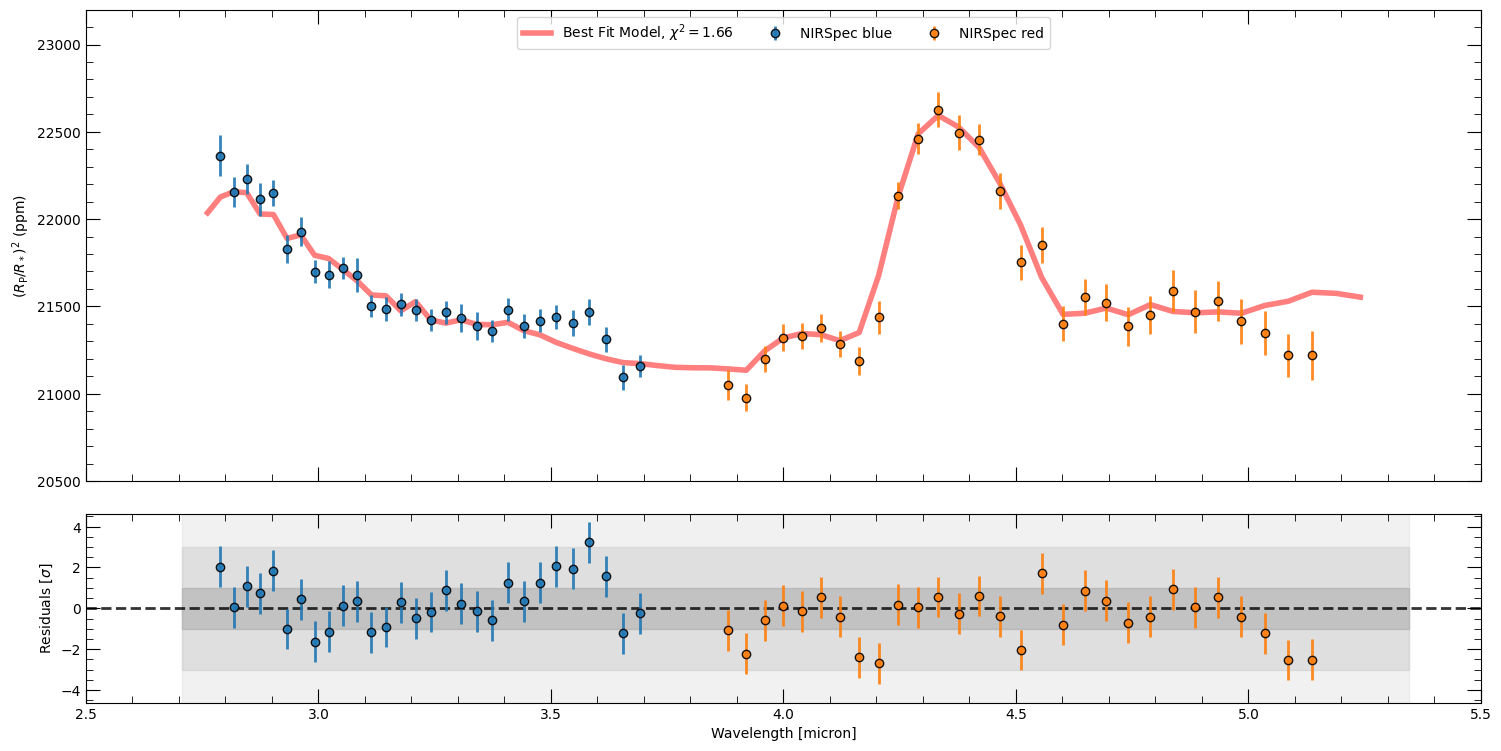

In [20]:
fig,ax,ax_r = retrieval.plot_spectra(samples_use,
                                     parameters_read,
                                     pRT_reference='NIRSpec blue')
plt.show()

After the calculation of the best fit spectrum, the retrieval object's parameter list will contain the best-fit values, so we make a [(deep!) copy](https://docs.python.org/3/library/copy.html) of it for use later:

In [24]:
import copy
best_fit_parameters = copy.deepcopy(retrieval.best_fit_params)

Next we will see the impact of individual absorbers on the best-fit spectrum. To this end we will turn off line absorbers one-by-one to see how the resulting spectrum changes. This "turning" off will be done by setting the abundances of the excluded species to very small values.

### Exercise 4:
Go through the code below and familiarize yourself with it. Please fill in the blank and put the log10(absorber abundance) of the species to be left out to a very low value (e.g., $-30$). [You can click here to see if your solution is correct](https://www2.mpia-hd.mpg.de/~molliere/SSW/solutions_notebook_2.html#Exercise-4:).


Plotting Best-fit spectrum
Best fit likelihood = 447.96
Best fit 𝛘^2/DoF = 1.66


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/retrieval/retrieval.py:2075: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


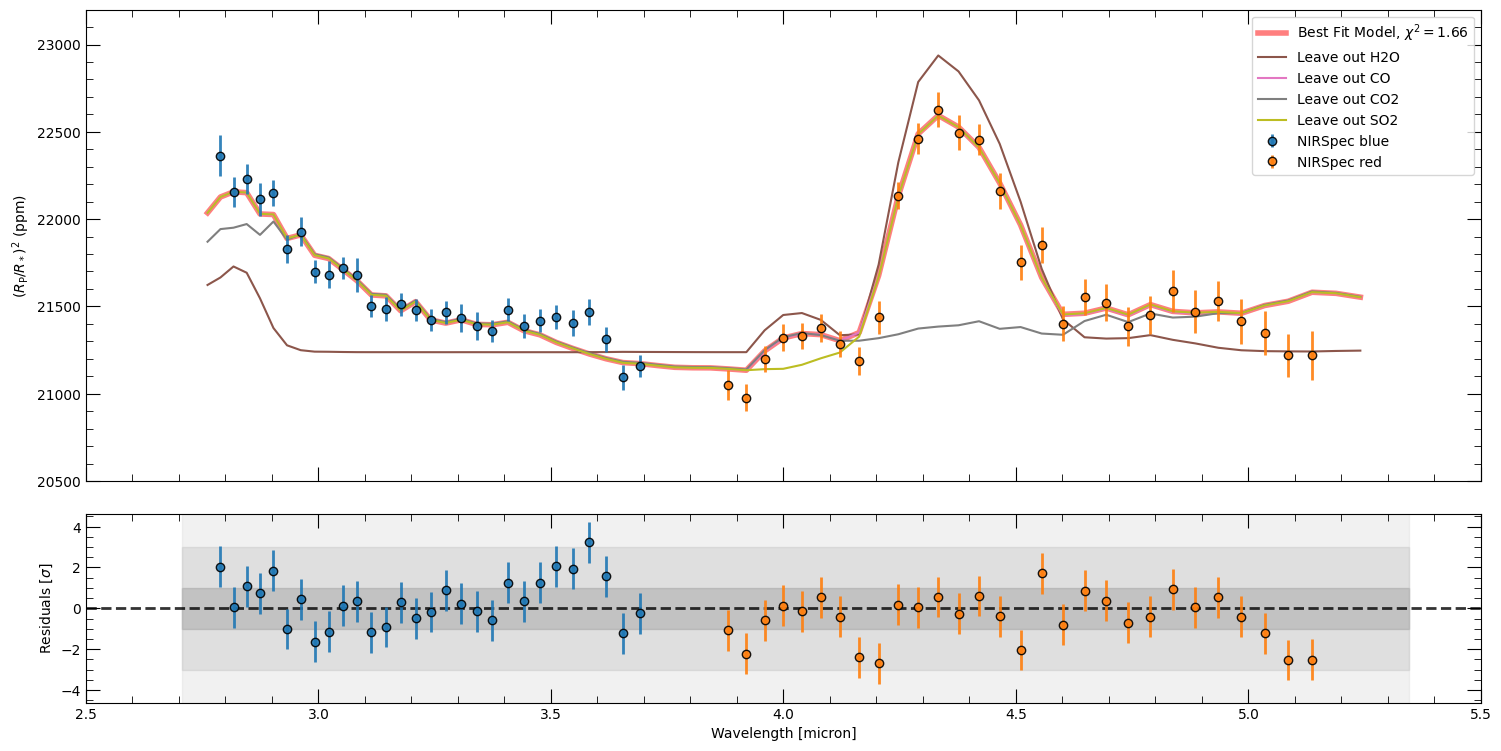

In [25]:
# Plot the best-fit spectrum including all absorber species
fig,ax,ax_r = retrieval.plot_spectra(samples_use,
                                     parameters_read,
                                     pRT_reference='NIRSpec blue')

# List of line absorbers to be left out:
leave_out = ['H2O_Exomol', 'CO_all_iso_HITEMP', 'CO2', 'SO2']

# Index selecting the plotting color
i_color = 5

# Loop through absorber list to turn them off one-by-one:
for species in leave_out:
  # Make a deep copy of the best_fit_parameters to locally change
  # abundances in the forward model computation
  input_params = copy.deepcopy(best_fit_parameters)

  # Exercise 4: fill in a low log10(absorber abundance) here
  # vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
  input_params[species].value = -10 # Fill in
  # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  # Calculate the transmission spectrum
  wlen, flux = WASP_39b_transmission_forward_model(
                            retrieval.data['NIRSpec blue'].pRT_object,
                            input_params)

  # Overplot on best-fit plot
  ax.plot(wlen, flux*1e6, label = 'Leave out '+species.split('_')[0],
          color = 'C'+str(i_color))

  i_color += 1

ax.legend()
plt.show()

You will also see that the overall height of the spectrum slightly changes when an important species such as water is left out. This is because the strength of the atmospheric features in a transmission spectrum is proportional to 1/mean molecular weight (1/MMW) for transmission spectra and MMW is a function of the abundances. Taking out water, a major absorber in the atmosphere, changes the mean molecular weight from $\sim$2.7 to $\sim$2.3.

### Exercise 5:
In the code cell below, fill in the blank and change the log10(cloud top pressure) to a very large value (e.g., 10, corresponding to $10^{10}$ bar), pushing the cloud deep below the probed atmosphere, to see the impact of the cloud on the best-fit spectrum. [You can click here to see if your solution is correct](https://www2.mpia-hd.mpg.de/~molliere/SSW/solutions_notebook_2.html#Exercise-5:).


Plotting Best-fit spectrum
Best fit likelihood = 447.96
Best fit 𝛘^2/DoF = 1.66


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/retrieval/retrieval.py:2075: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


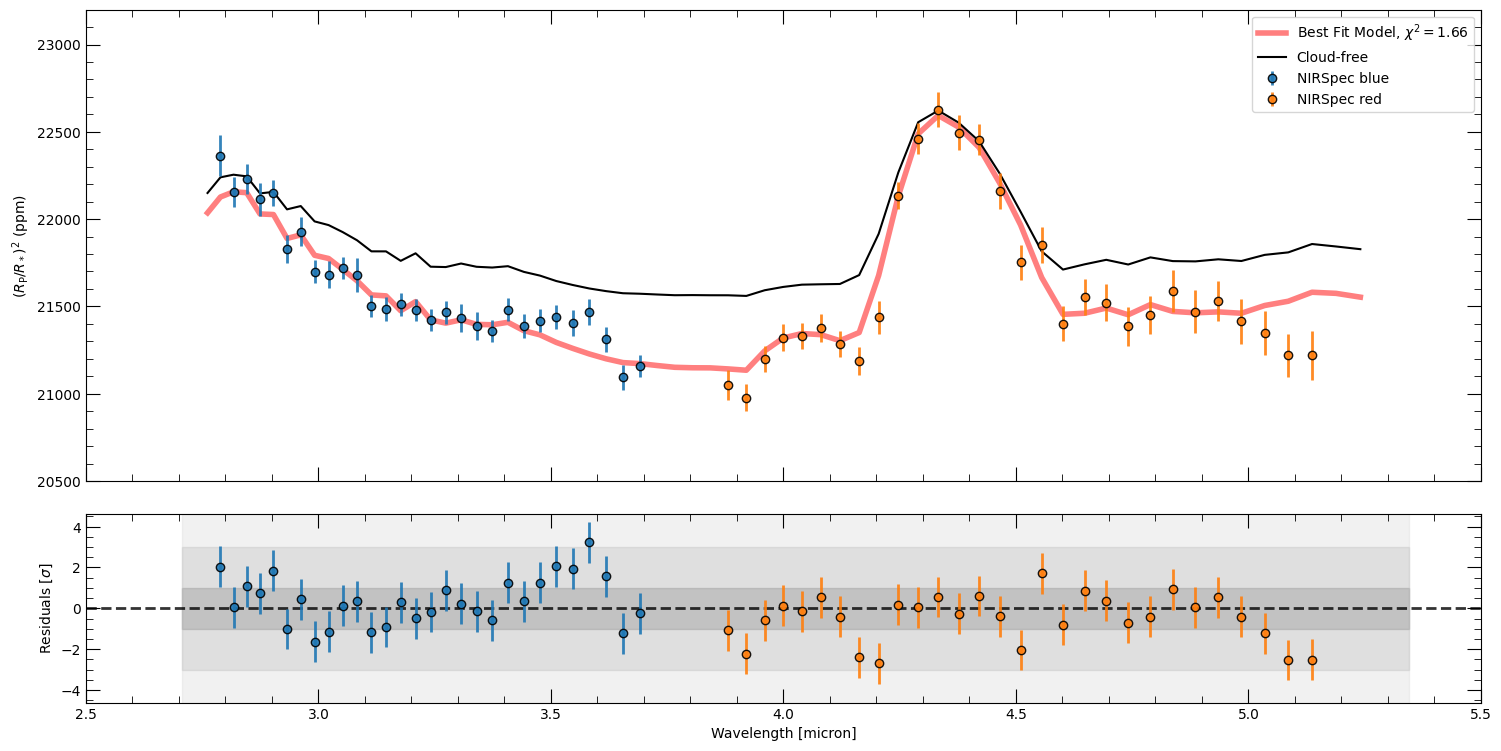

In [26]:
# Plot the best-fit spectrum including all absorber species
fig,ax,ax_r = retrieval.plot_spectra(samples_use,
                                     parameters_read,
                                     pRT_reference='NIRSpec blue')

# Make a deep copy of the best_fit_parameters
input_params = copy.deepcopy(best_fit_parameters)

# Exercise 4: fill in a high log10(cloud top pressure) here
# vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
input_params['log_Pcloud'].value = -4 # Fill in
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

# Calculate the transmission spectrum
wlen, flux = WASP_39b_transmission_forward_model(
                          retrieval.data['NIRSpec blue'].pRT_object,
                          input_params)

# Overplot on best-fit plot
ax.plot(wlen, flux*1e6, label = 'Cloud-free', color = 'black')

ax.legend()
plt.show()

### Corner plots
Below you see how to make a corner plot.

### Exercise 6:
Given the uncertaintes of the absorber abundances, which species do you think play a role in the spectrum? How does this compare to the "leave-one-species-out" plotting study above? Note that a corner plot and the corresponding abundance posteriors should not be used to assess the detection significance of a species, however. For this a proper model selection analysis is required, see the bonus exercise below.


Making corner plot


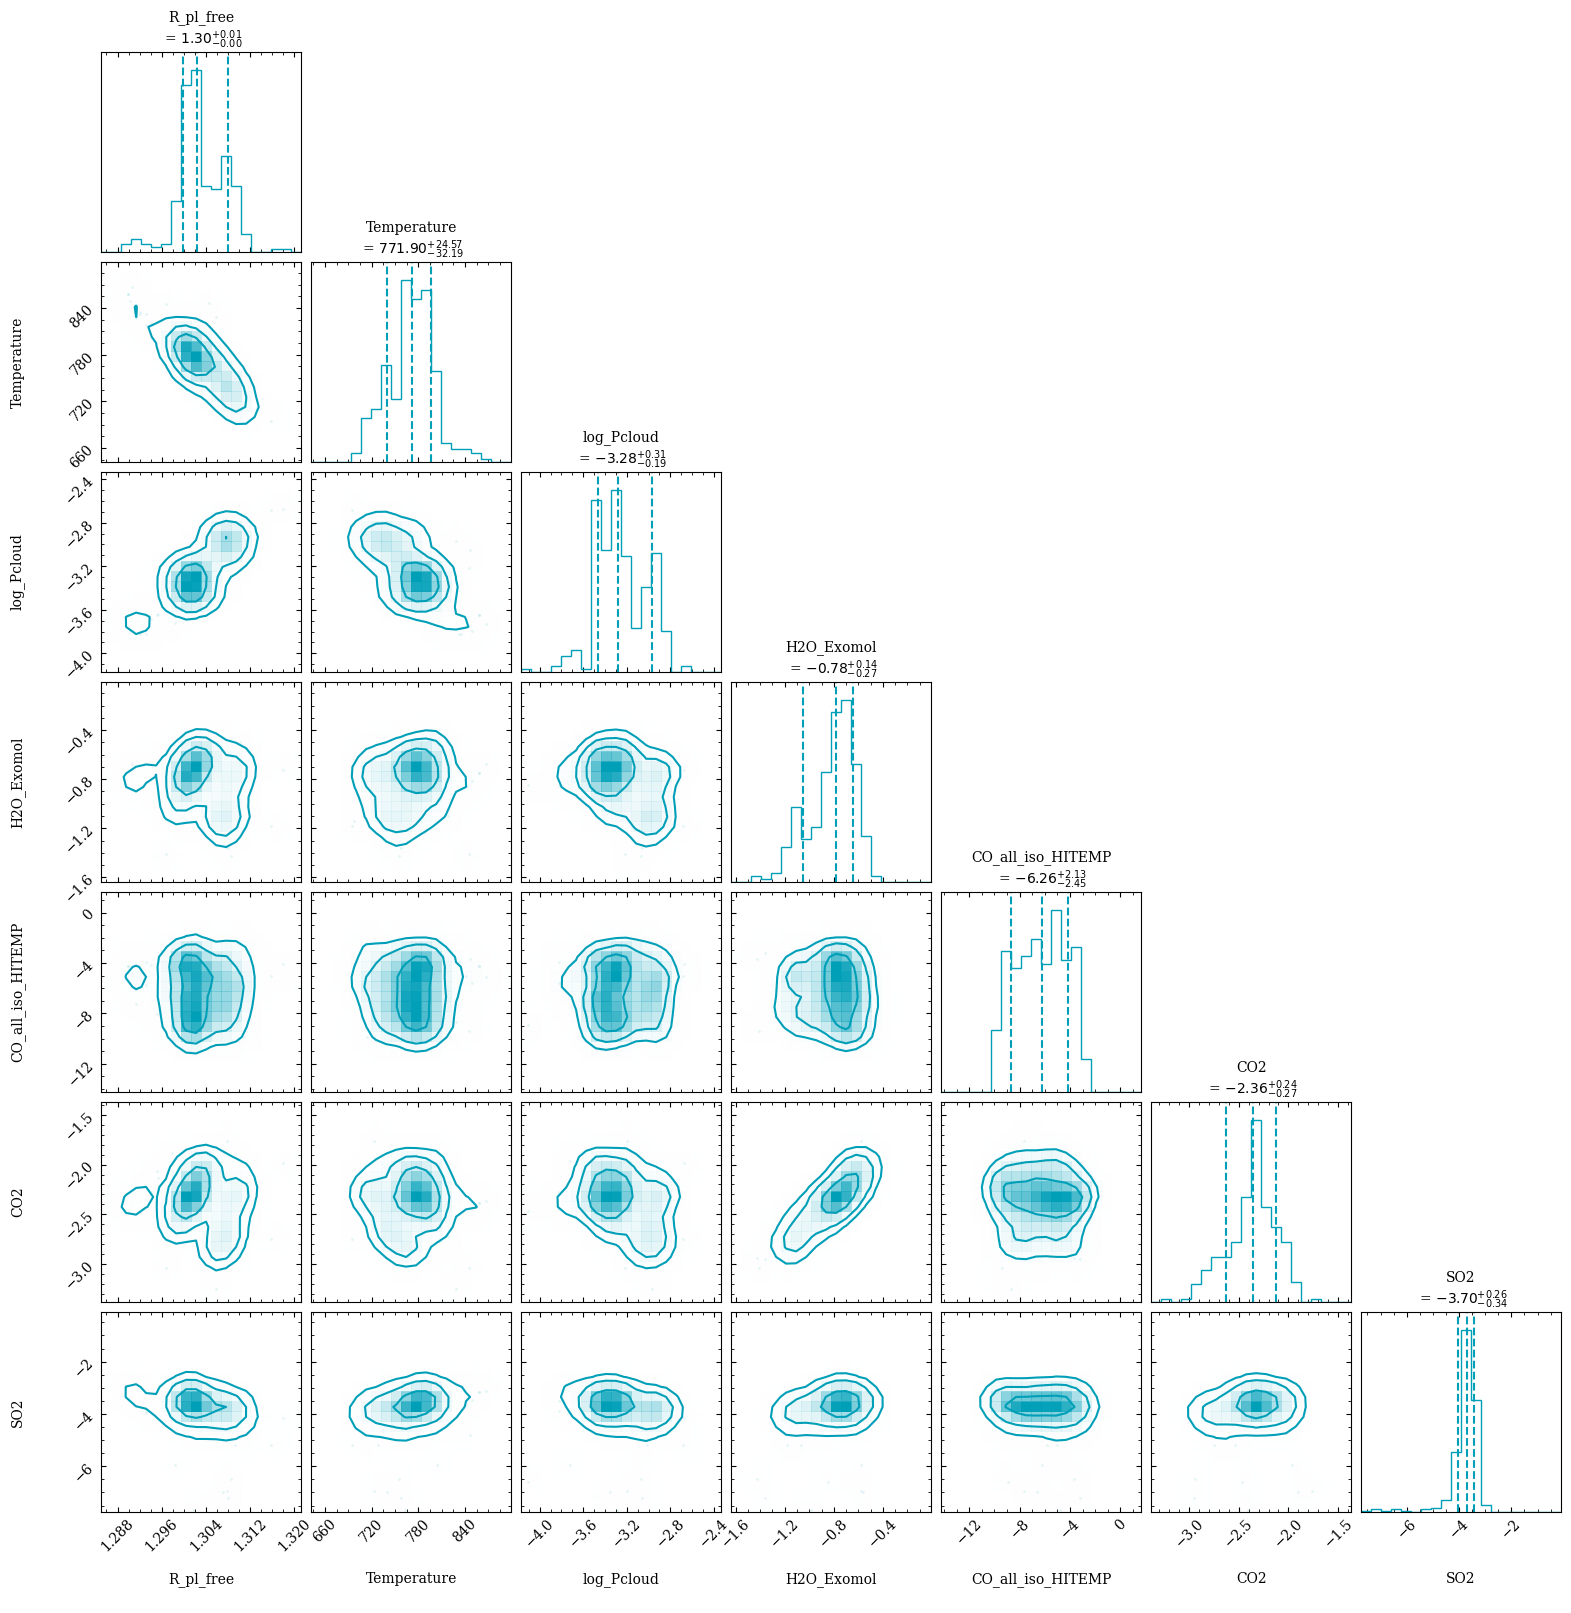

In [27]:
retrieval.plot_corner(sample_dict,
                      parameter_dict,
                      parameters_read,
                      title_kwargs = {"fontsize" : 10})

plt.show()

### Pressure-temperature envelopes
For completeness, this is how to plot the distribution of pressure-temperature profiles resulting from the retrieval. Since we used a isothermal profile it is kinda boring in our case.


Plotting PT profiles
Best fit likelihood = 447.96


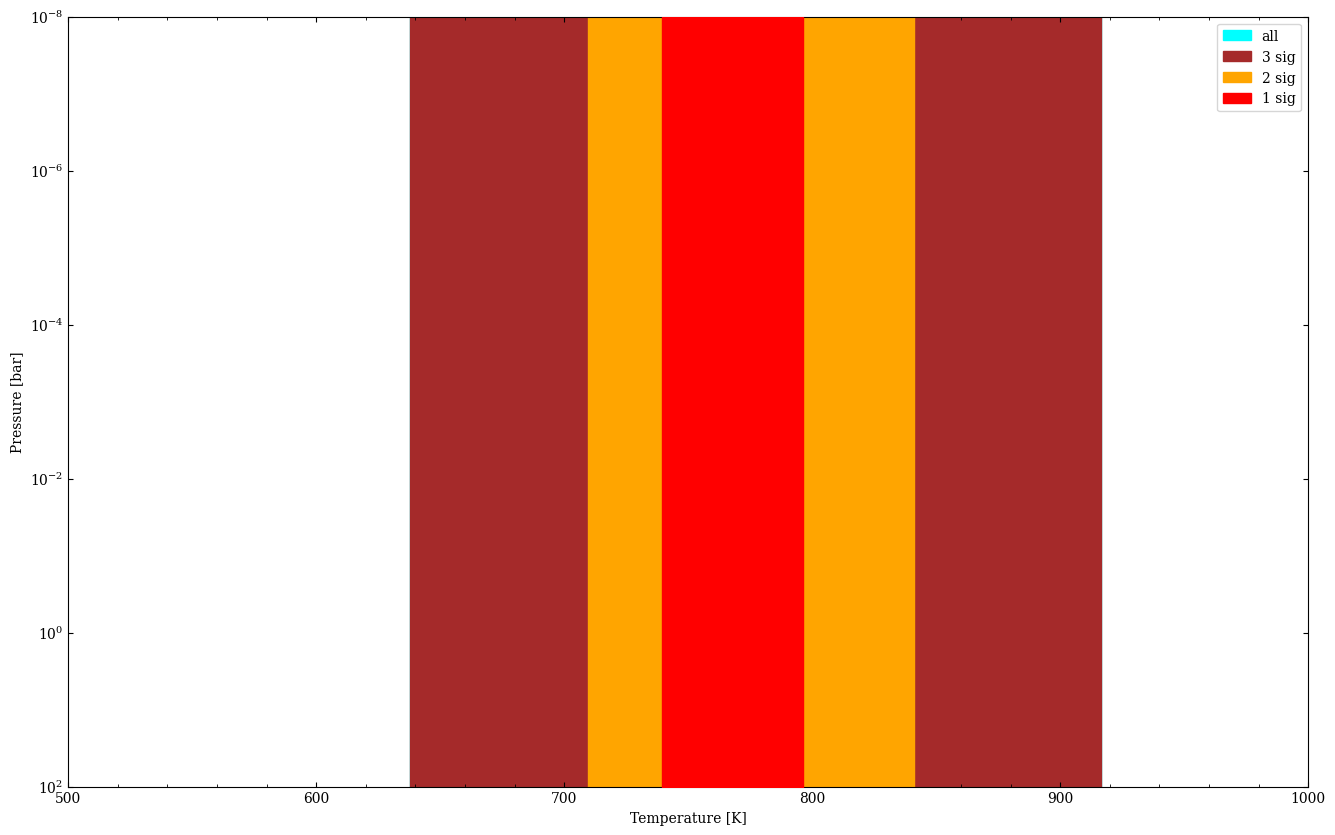

In [28]:
fig,ax =retrieval.plot_PT(sample_dict,
                          parameters_read,
                          contribution = False)
plt.ylim([1e2,1e-8])
plt.show()

# The END
We are done with the retrieval hands-on notebooks, congratulations! In case you still have time, or can make time for it later: there is a bonus exercise on model selection attached below.

# Bonus: Model selection

With nested sampling it also becomes possible to answer this question: "*Given the data, which of my tested forward models is the most likely one?*" Here we do not mean which parameters of a given model are the most likely ones, but which model is the most likely one, among a set of tested models. Examples for different models would be one that uses an isothermal temperature profile and one that uses the Guillot profile. Or one model that includes more molecules than another one. This is clearly a useful analysis. Note, however, that it does not allow us to find the correct or best model in absolute terms. All it allows is to select the most likely model from a set of models. It could be that there's an even more probable model that has not been explored yet. Alternatively put: there's also the danger to select the "best" model from a set of bad or unphysical models.

Model selection is done via the so-called Bayes factor, which is defined as follows
$$B_{12} = \frac{P(\mathbf{y}|\mathcal{M}_1)}{P(\mathbf{y}|\mathcal{M}_2)},$$
where $P(\mathbf{y}|\mathcal{M}_i)$ is the probablity to observe the data $\mathbf{y}$, given that the physical processes giving rise to the data are correctly described by model $\mathcal{M}_i$. Using Bayes' theorem, we can write
$$
B_{12} = \frac{P(\mathcal{M}_1|\mathbf{y})}{P(\mathcal{M}_2|\mathbf{y})}\frac{P(\mathcal{M}_2)}{P(\mathcal{M}_1)}.
$$
If we assume that we do not have any prior information on which model is preferable ($P(\mathcal{M}_i)=P(\mathcal{M}_j) \ \forall \ i,j$) we get
$$
B_{12} = \frac{P(\mathcal{M}_1|\mathbf{y})}{P(\mathcal{M}_2|\mathbf{y})},
$$
which is what we want: this is the ratio of model probabilities, given the data.

Now, the Multinest method actually calculates $P(\mathbf{y}|\mathcal{M})$ during the retrieval which is also called evidence $Z$ (and sometimes "marginal likelihood").
The evidence $Z$ is calculated in Multinest by numerical integration
\begin{align}
Z & = P(\mathbf{y}|\mathcal{M}_1) \\ &
= \int P(\mathbf{y}|\mathbf{x})P(\mathbf{x}|\mathcal{M})d\mathbf{x} \\
& = \int \underbrace{P(\mathbf{y}|\mathbf{x})}_{\rm likelihood}\underbrace{P(\mathbf{x})}_{\rm prior}d\mathbf{x},
\end{align}
where we dropped the (still implied) $\mathcal{M}$-dependence on the prior of $\mathbf{x}$. So here we encounter two old acquaintances again: the prior and the likelihood. Nested sampling thus does nothing other than numerically integrating the evidence $Z$ using a Monte Carlo scheme. The samples of the posterior are a (highly useful) by-product of this process. A nice reference for learning more about nested sampling is [this overview paper](https://arxiv.org/abs/2101.09675). In summary it thus holds that
\begin{equation}
B_{12} = \frac{Z_1}{Z_2},
\end{equation}
which is the equation we will use below.

#### Accessing the evidence
We can access the evidence of a finished retrieval by looking at the retrieval summary file mentioned above, or by accessing the run_name_stats.json file in the out_PMN folder, which contains the output of Multinest:

In [29]:
import json
with open('out_PMN/'+run_name+'_stats.json') as f:
    stats = json.load(f)

lnZ = stats['global evidence']
delta_lnZ = stats['global evidence error']

print('ln(Evidence)', lnZ, '\nError of ln(Evidence)', delta_lnZ)

ln(Evidence) 422.8668963633944 
Error of ln(Evidence) 0.04529113773008941


### Exercise 7:
The tentative discovery of SO$_2$ is an important result of the ERS team's study on WASP-39b. The evidence we'd get with our model above, if leaving out SO$_2$ as an absorber species during the run definition, is ${\rm ln}(Z_{\rm no \ SO_2}) = 421.5$. Given the evidence we derived for the full model above, how much more likely is the model including SO$_2$? Note that this value will vary somewhat from retrieval to retrieval, due to the Monte Carlo nature of nested sampling.  [You can click here to see if your solution is correct](https://www2.mpia-hd.mpg.de/~molliere/SSW/solutions_notebook_2.html#Exercise-7:).

In [31]:
print(np.exp(lnZ - 421.5)) # Fill in

3.923155731154037


### Ecercise 8:
The table below allows to convert from Bayes factors to detection significance, taken from [Benneke & Seager (2013)](https://arxiv.org/pdf/1306.6325.pdf). What is the detection significance of SO$_2$, following their method?

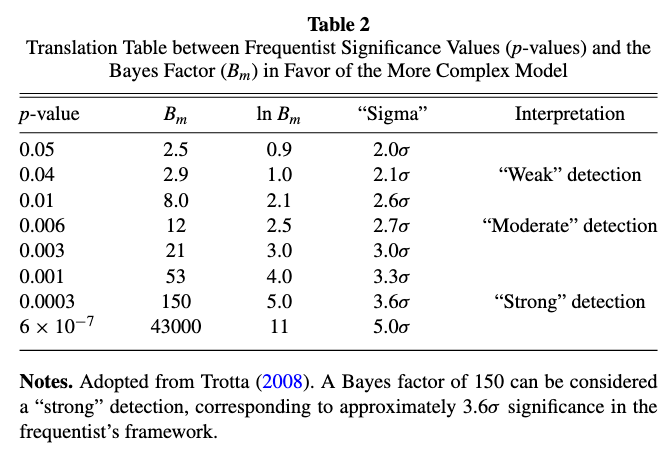

The solution should be: about 2-3 $\sigma$. So not very high. You'd also obtain this result if you did not bin down the G395H spectrum. We found that from the G395H data alone, the reported ~4.5$\sigma$ detection can only be obtained if using the observation at full resolution, and when using a "fancier" cloud model than we used here (e.g., [this one](https://petitradtrans.readthedocs.io/en/latest/content/notebooks/clouds.html#Defining-arbitrary-opacity-functions-(can-be-used-to-parameterize-clouds))). Since that would have more free parameters (and would thus be too slow for running on Colab in a few minutes) we sticked with a simple gray cloud model here.

# Running more complicated retrievals (on multiple cores)
If you want to run more complicated (and therefore numerically expensive) retrievals in the future, we recommend to run pRT elsewhere (so don't run it in a notebook, pRT on a single core is too slow). [Also make sure to download the full input_data folder for this](https://petitradtrans.readthedocs.io/en/latest/content/installation.html#pre-installation-download-the-opacity-data); here we only used a smaller version, with less absorber species and at lower resolution, such that it fit into your Google Drives without a problem. What also helps a lot is that retrieval samples can be generated in parallel, such that many forward model realizations will be calculated multiples cores simultaneously.

If you have a multi-core processor (which is true for pretty much everyone these days) you can run the retrievals on multiple cores. Just use ``mpiexec -n 4 python your_script.py`` to run your retrieval on 4 cores, for example. Note that you have to have mpi4py installed for this to work, as [discussed in the PyMultiNest manual](https://johannesbuchner.github.io/PyMultiNest/pymultinest.html#using-pymultinest-with-mpi). ``your_script.py`` would basically contain the retrieval setup as outlined above, adapted to your needs.

**Note that if you specify a certain spectral resolution for your model that you have never used before, then pRT has not saved the corresponding binned-down opacity data to pRT's ``input_data`` folder yet. So it needs to rebin them on the fly. In this case you have to run your retrieval object initialization (``retrieval = Retrieval(run_definition, ...)``) once using a single core, because the rebinning does not work when running in parallel.**

## Running on a cluster
At [MPIA](http://www.mpia.de/de) we are using the [Slurm Workload Manager](https://en.wikipedia.org/wiki/Slurm_Workload_Manager) to manage jobs on our cluster. In our case we can start a retrival by typing ``sbatch sub_pRT``. This is what our submit script (called ``sub_pRT``) looks like, running on 4 nodes with 40 cores (160 cores in total):
```
#!/bin/bash -l

#SBATCH -o ./out/job.out.%j
#SBATCH -e ./out/job.err.%j
#SBATCH -D ./
#SBATCH -J Retrieval_Name
#SBATCH --nodes=4
#SBATCH --tasks-per-node=40
#SBATCH --cpus-per-task=1
#SBATCH --time=48:00:00
#SBATCH --mail-type=ALL
#SBATCH --mail-user=specify_your_email_address

module purge
module load impi
module load anaconda
module load multinest
export PYTHONPATH=/u/pmolliere/retrieval_project/:$PYTHONPATH
export pRT_input_data_path=/u/pmolliere/retrieval_project/input_data

srun python your_script.py
```
**Your script will likely look somewhat, maybe even a lot, different, because every cluster is different**! Maybe ask your local IT expert?

# No SO$_2$ retrieval

For your reference, the retrieval that neglects the SO$_2$ as an absorbing species is given below. We will not run it here because adding another retrieval will take slightly too long for this hands-on session. Please use the evidence ${\rm ln}(Z_{\rm no \ SO_2})$, given above, instead.

In [ ]:
run_mode = 'retrieve' # or 'retrieve' or 'evaluate'
run_name_no_SO2 = 'transmission_WASP-39b_no_SO2'

RunDefinition_no_SO2 = RetrievalConfig(retrieval_name = run_name_no_SO2,
                                      run_mode = run_mode,
                                      scattering = False,
                                      pressures=np.logspace(-8, 2, 30))



line_species = ['H2O_Exomol',
                    'CO_all_iso_HITEMP',
                    'CO2']
rayleigh_species = ['H2', 'He']
continuum_opacities = ['H2-H2', 'H2-He']

RunDefinition_no_SO2.set_rayleigh_species(rayleigh_species)
RunDefinition_no_SO2.set_continuum_opacities(continuum_opacities)
RunDefinition_no_SO2.set_line_species(line_species,
                               eq=False,
                               abund_lim = (-10.0,0.0))

RunDefinition_no_SO2.add_parameter('R_star',
                             False,
                             value = input_R_star)
RunDefinition_no_SO2.add_parameter('M_pl',
                             False,
                             value = input_M_pl)
RunDefinition_no_SO2.add_parameter('R_pl',
                             False,
                             value = input_R_pl)

RunDefinition_no_SO2.add_parameter('R_pl_free',
                             True,
                             transform_prior_cube_coordinate =
                                  lambda x : (0.5 + 1.0*x) * nc.r_jup)

RunDefinition_no_SO2.add_parameter('Temperature',
                             True,
                             transform_prior_cube_coordinate =
                                  lambda x : (200 + 1800.0*x))

RunDefinition_no_SO2.add_parameter('log_Pcloud',
                             True,
                             transform_prior_cube_coordinate =
                                  lambda x : (-8 + 10*x))

RunDefinition_no_SO2.add_data('NIRSpec blue',
                       '../observations/weighted_average_WASP_39b_'
                       'transmission_1_R100_pRT_grid.dat',
                       model_generating_function = WASP_39b_transmission_forward_model,
                       opacity_mode = 'c-k',
                       data_resolution = None,
                       model_resolution = 100,
                       pRT_grid = True,
                       wlen_range_micron = [2.75, 5.25])

RunDefinition_no_SO2.add_data('NIRSpec red',
                       '../observations/weighted_average_WASP_39b_'
                       'transmission_2_R100_pRT_grid.dat',
                       model_generating_function = WASP_39b_transmission_forward_model,
                       opacity_mode = 'c-k',
                       data_resolution = None,
                       model_resolution = 100,
                       pRT_grid = True,
                       external_pRT_reference = 'NIRSpec blue')


RunDefinition_no_SO2.plot_kwargs["spec_xlabel"] = 'Wavelength [micron]'
RunDefinition_no_SO2.plot_kwargs["spec_ylabel"] = r"$(R_{\rm P}/R_*)^2$ (ppm)"
RunDefinition_no_SO2.plot_kwargs["y_axis_scaling"] = 1e6
RunDefinition_no_SO2.plot_kwargs["xscale"] = 'lin'
#RunDefinition_no_SO2.plot_kwargs["wavelength_lim"] = [5., 11.]
RunDefinition_no_SO2.plot_kwargs["flux_lim"] = [20900,22900]
RunDefinition_no_SO2.plot_kwargs["yscale"] = 'linear'
RunDefinition_no_SO2.plot_kwargs["resolution"] = None
RunDefinition_no_SO2.plot_kwargs["nsample"] = 10.
RunDefinition_no_SO2.parameters['R_pl_free'].corner_transform = lambda x: x / nc.r_jup

RunDefinition_no_SO2.plot_kwargs["take_PTs_from"] = 'NIRSpec blue'
RunDefinition_no_SO2.plot_kwargs["temp_limits"] = [0,2000]
RunDefinition_no_SO2.plot_kwargs["press_limits"] = [1e3, 1e-6]

for param in RunDefinition_no_SO2.parameters.keys():
    if RunDefinition_no_SO2.parameters[param].is_free_parameter:
        RunDefinition_no_SO2.parameters[param].plot_in_corner = True

retrieval_no_SO2 = Retrieval(RunDefinition_no_SO2,
                      test_plotting = False,
                      pRT_plot_style = False)

retrieval_no_SO2.run(n_live_points = 50,
              const_efficiency_mode=False,
              sampling_efficiency = 0.8,
              resume = True)